# Figure 6 - Paper 1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime

import matplotlib.pyplot as plt
from src.utils import save_name
from src.utils import modif_plot

from src.data_preparation import load_data

In [2]:
import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

# LOAD THICKNESS

In [4]:
# new way: use merge_TOPAZ

In [3]:
from src.data_preparation import merge_TOPAZ

In [4]:
from importlib import reload

In [5]:
reload(merge_TOPAZ)

<module 'src.data_preparation.merge_TOPAZ' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/merge_TOPAZ.py'>

## Too heavy for login node

In [6]:
sit_ml, chrono_dt, sit_na, sit_bl, sit_mlm, sit_nam, sit_blm = merge_TOPAZ.load(return_na=True, return_bl=True, return_mean=True)

Import...
	1991-1998
	1999-2010


MemoryError: Unable to allocate 7.09 GiB for an array with shape (4413, 479, 450) and data type float64

In [39]:
sit_ml, chrono_dt = merge_TOPAZ.load_nc()
sit_mlm = sit_ml.mean(('x','y'))

sit_fr = merge_TOPAZ.load_freerun()
sit_frm = sit_fr.mean(('x','y'))

sit_bl, _ = load_data.load_nc('/scratch/project_465000269/edelleo1/Leo/TP4_ML/sit_bl_2000_2011_adjSIC.nc', 'sithick', X_only=True)
sit_blm = sit_bl.mean(('x','y'))

sit_a = merge_TOPAZ.load_ass(return_mean=False)  # sit_am # True)
sit_am = sit_a.mean(('x','y'))

Loading ML-SIT...
	1992-1998
	1999-2010
	2011-2022
Merging...
Loading...
Merging...


KeyboardInterrupt: 

In [9]:
# Rename for easy data manipulation
sit = sit_ml

# DATA Manipulation: compute distribution

remove open water fraction

In [10]:
# Cap negative value at 0 m (while keeping nan)
sit0 = (sit.where((0<sit), -999)).where(np.isfinite(sit))

In [11]:
sit_nan = (sit.where((0<=sit))).where(np.isfinite(sit))  # exclude open ocean (SIT=0m)
# and all values -999 are nan (for histogram fit)

In [12]:
# # need to get monthly mean
sit_mm = sit.resample(time='1M').mean()

# # change time axis to first day of each month
time_idx = sit_mm.time.to_index()
sit_mm['time'] = [datetime.datetime(t.year, t.month, 1) for t in time_idx]
chrono_mm = pd.DataFrame({'date':pd.to_datetime(sit_mm['time'].to_numpy())})

In [13]:
# histogram
bin_width = 0.1
bins = np.arange(0,8+bin_width,bin_width)

In [14]:
# compute for all time steps (daily or monthly)

def compute_distri_time(sit, bins=None, bin_width=None):
    '''
    Returns distribution (pdf) of SIT over time
    
    
    Parameters:
    -----------
    
        sit           :      xarray of dimension (time, y, x)
        bins          :      array of bins. if None, will select values for thickness categories from TOPAZ5
        bin_width     :      float. If given, bins between 0 and 8 meters will be created spaced by bin_width
    '''
    
    if bins is None:
        bins = np.array([0, 0.64, 1.39, 2.47, 4.57, 20]) # from icecat TOPAZ5
    if bin_width is not None:
        bins = np.arange(0,8+bin_width,bin_width)
    
    distri = np.zeros((sit.shape[0], bins.size-1))
    
    ntime = sit.shape[0]
    
    for nt in range(ntime)[:]:
        # remove nan: from xarray.plot.hist()
        no_nan = np.ravel(sit.isel(time=nt).to_numpy())
        no_nan = no_nan[pd.notnull(no_nan)]
        
        hist, _ = np.histogram(no_nan, bins=bins) # , density=True)
        distri[nt] = hist/sum(hist)
#         distri[nt] = hist/sum(hist)
    
    
    dist = xr.DataArray(distri.T,
                        coords={'bins': bins[:-1], 'time': sit.time}, 
                        dims=["bins", "time"])
    
    return dist


In [15]:
sit_dist = compute_distri_time(sit, bin_width=0.1)

In [18]:
sit_dist0 = compute_distri_time(sit0, bin_width=0.1)

KeyboardInterrupt: 

In [ ]:
# to get fraction on TOPAZ5 SIT bins
sit_frac = compute_distri_time(sit0)

In [ ]:
# to get fraction on TOPAZ5 SIT bins
sit_frac2 = compute_distri_time(sit0, bins=np.array([0,3,4,20]))

--------------------

In [ ]:
# Plot SIT FRACTION (between 0-1) for paper
# To know the evolution of SIT > 4.6m between 1991 and 2022
# or maybe 2.7m ?

In [ ]:
sit_frac.shape

In [ ]:
cat_TP5 = [0, 0.64, 1.39, 2.47, 4.57] # and above 4.57
label_cat = ['< 0.64m', '< 1.39m', '< 2.47m', '< 4.57m ', '> 4.57m ']


fig, axes = plt.subplots(nrows=1, figsize=(14,6), constrained_layout=True)

for n in range(len(cat_TP5)):
    sit_frac.isel(bins=slice(None,n+1)).sum(dim='bins').plot(ax=axes, label=label_cat[n])

axes.axhline(y=0, ls='--', color='grey', alpha=0.6)
axes.set_ylabel('sit_fraction of sea ice')
axes.set_xlabel('')    
axes.set_xlim([sit_frac.time[0],sit_frac.time[-1]])
axes.set_ylim([-0.05, 1.05])
axes.set_yticklabels(['','0','0.2','0.4','0.6','0.8','1'])

plt.legend(ncol=5, loc='lower center');

In [ ]:
cat_TP5 = [0, 3, 4] # and above 4.57
label_cat = ['< 0m', '< 3m', '< 4m']


fig, axes = plt.subplots(nrows=1, figsize=(14,6), constrained_layout=True)

for n in range(len(cat_TP5)):
    sit_frac2.isel(bins=slice(None,n+1)).sum(dim='bins').plot(ax=axes, label=label_cat[n])

axes.axhline(y=0, ls='--', color='grey', alpha=0.6)
axes.set_ylabel('sit_fraction of sea ice')
axes.set_xlabel('')    
axes.set_xlim([sit_frac2.time[0],sit_frac.time[-1]])
axes.set_ylim([-0.05, 1.05])
axes.set_yticklabels(['','0','0.2','0.4','0.6','0.8','1'])

plt.legend(ncol=5, loc='lower center');

In [ ]:
sfrac= sit_frac.isel(bins=slice(None,3)).sum(dim='bins')  # bins 3 = <2.5m

In [ ]:
sfrac1=sfrac.resample(time='1M').interpolate('linear')

In [ ]:
(1-sfrac1).plot()
plt.title('SIT >2.5m yearly average over the Arctic');

In [ ]:
# Average fraction of SIT > 2.5m in 1991
(1-sfrac1.isel(time=slice(None,12))).mean()

In [ ]:
# Average fraction of SIT > 2.5m in 2022
(1-sfrac1.isel(time=slice(-12,None))).mean()

In [93]:
sfrac2= sit_frac2.isel(bins=slice(None,1)).sum(dim='bins')

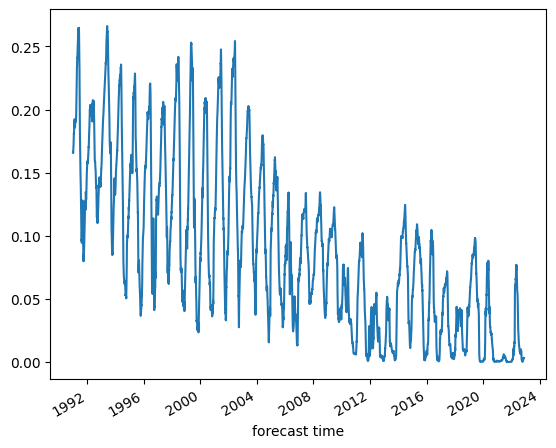

In [94]:
(1-sfrac2).plot()

In [95]:
# Average fraction of SIT > 3m in 1991
(1-sfrac2.isel(time=slice(None,365))).mean()

<xarray.DataArray ()>
array(0.16553382)

In [96]:
# Average fraction of SIT > 3m in 2022
(1-sfrac2.isel(time=slice(-365,None))).mean()

<xarray.DataArray ()>
array(0.01891002)

--------------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


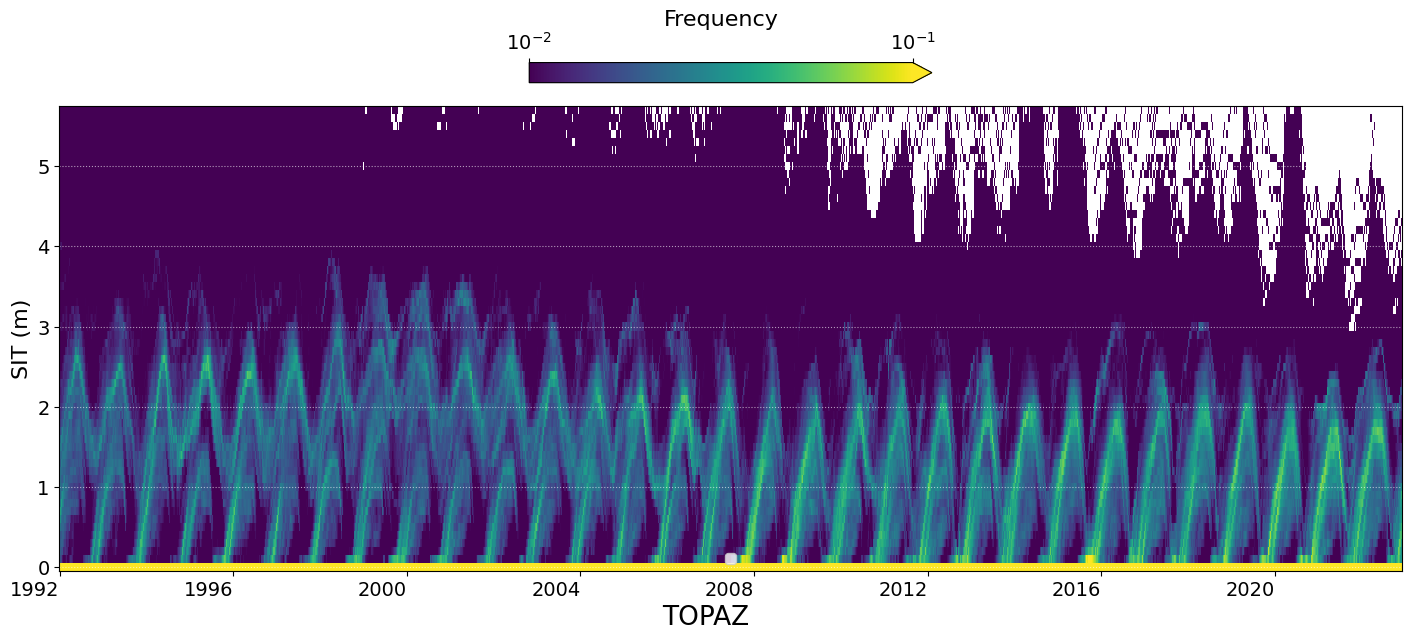

In [32]:
draw_dist(sit_dist, savefig=False, showfig=True)

In [33]:
draw_sit(s1, showfig=True)

NameError: name 's1' is not defined

In [37]:
draw_dist_sit(sit_dist0, s1)

NameError: name 'sit_dist0' is not defined

In [35]:
draw_dist_sit(sit_dist0, sit_am=sit_am, sit_nam=sit_nam, sit_m=sit_mlm, sit_blm=sit_blm, showfig=True)

NameError: name 'sit_dist0' is not defined

In [38]:
draw_dist_sit_uneven(sit_dist0, sit_am=sit_am, sit_nam=sit_nam, sit_m=sit_mlm, sit_blm=sit_blm, showfig=True)

NameError: name 'sit_am' is not defined

In [21]:
draw_dist_sit_uneven(sit_dist0, sit_am=sit_am, sit_nam=sit_nam, sit_m=sit_mlm, sit_blm=sit_blm, showfig=True)

NameError: name 'sit_am' is not defined

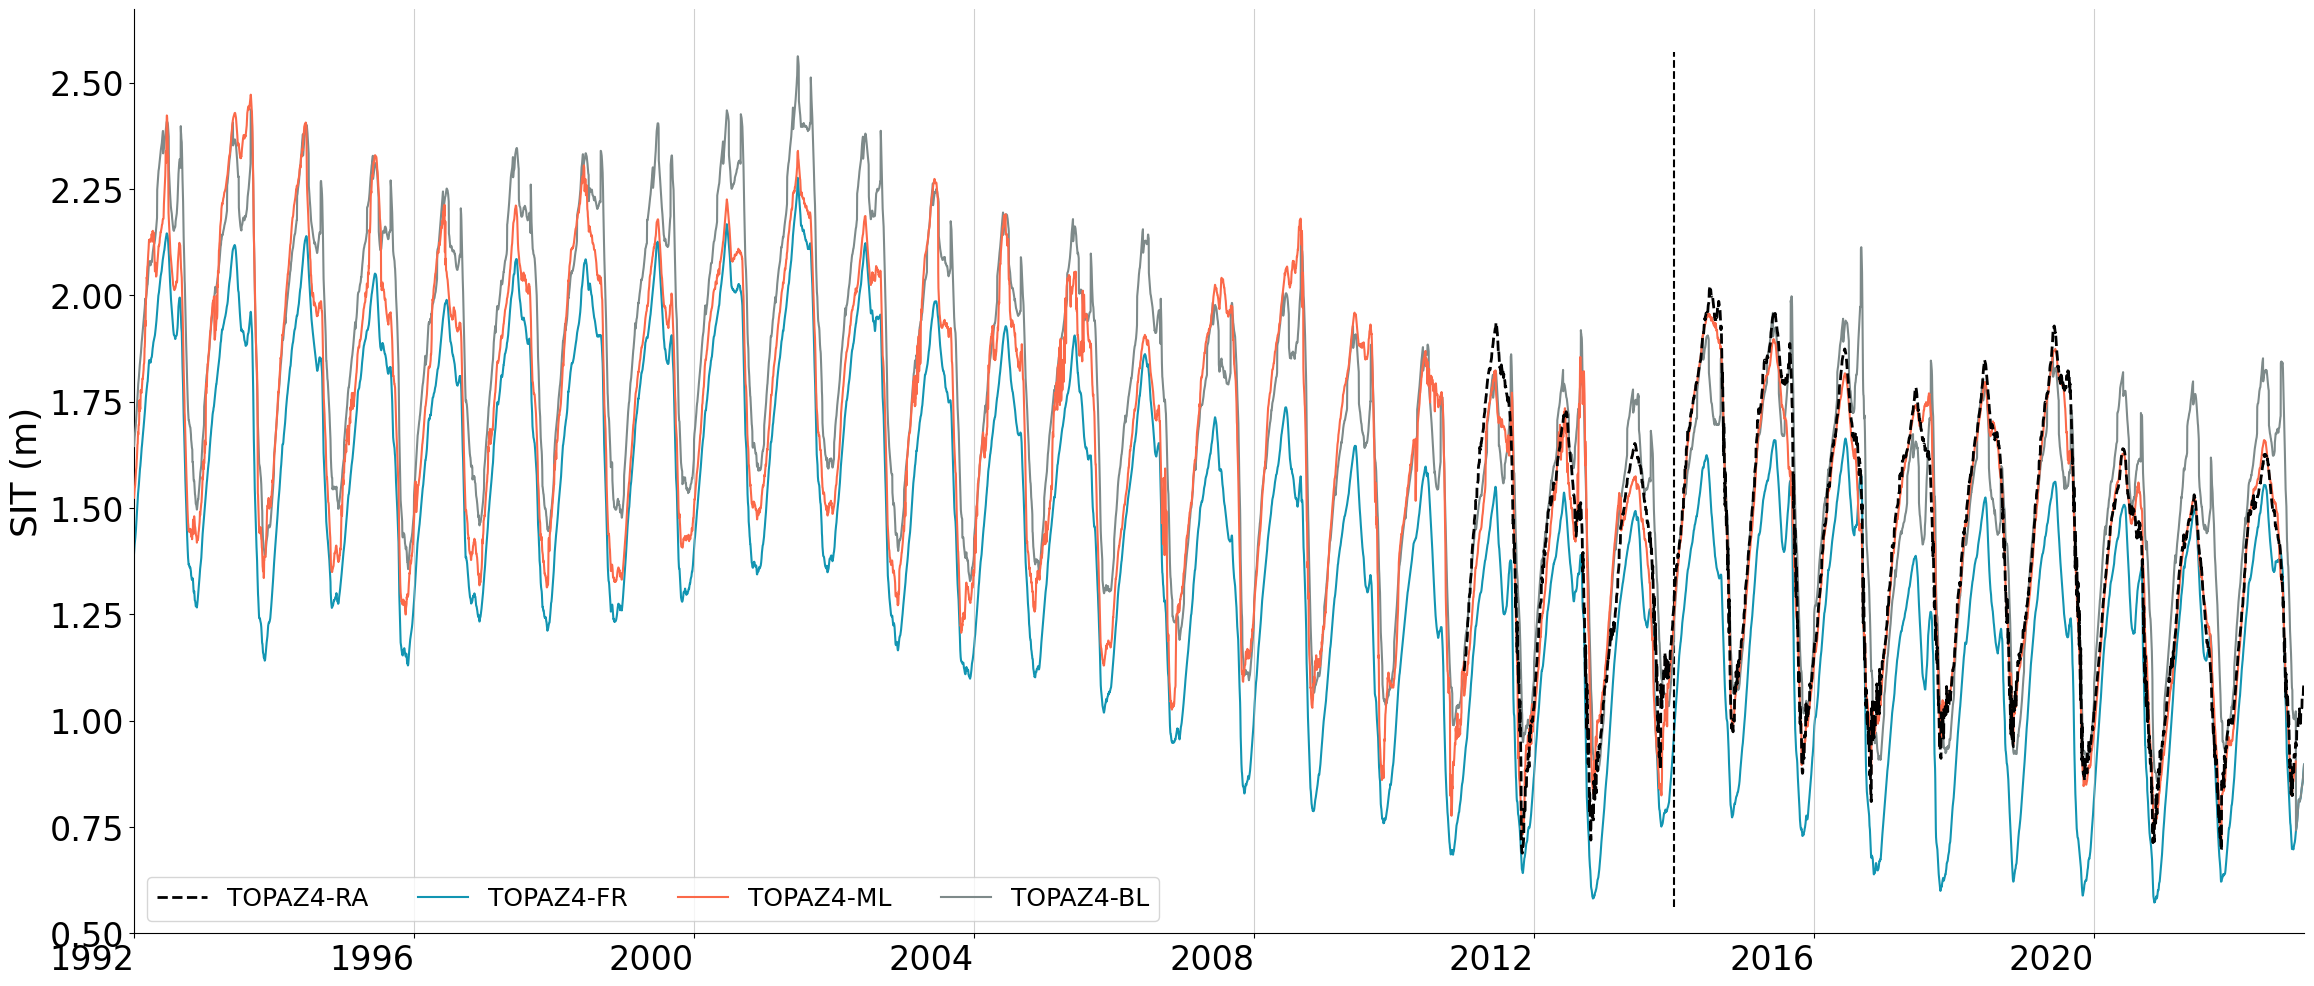

In [ ]:
draw_sit_30y(sit_am=sit_am, sit_nam=sit_nam, sit_m=sit_mlm, sit_blm=sit_blm, showfig=True)

# PLOT

In [23]:
def draw_sit_30y(sit_am, sit_nam, sit_m, sit_blm, tp_model='', savefig=False, showfig=True, rootdir=None, fig_dir=None):
    ''' 
    Draw time series of SIT for:
            - ML reconstruction
            - TOPAZ4b FreeRun
            - baseline
            - TOPAZ 4b (our 'truth')
    
    Parameters:
    -----------
    tp_model     :     string, TOPAZ version used. Ex: 4b, 4bFR, or ML-corrected: LSTM, RF, CNN
    sc           :  SITCorrected instance
    '''
    from matplotlib.colors import LogNorm
    from matplotlib import gridspec  # uneven subplot
    
    # GridSpec tuto:
    # http://127.0.0.1:6868/?token=5ce1e1a313df890cbc23e9240932c9523b747b308604c37a
    fig = plt.figure(figsize=(28,12), constrained_layout=True)
    gs = gridspec.GridSpec(20, 20)
    ax1 = fig.add_subplot(gs[:, :])
    #ax1 = fig.add_subplot(gs[9:, :])

    mini = 0.001
    maxi = 0.1
       
    # cut at 5m of SIT as very little to see above
  #  imC = dist.isel(bins=slice(None,58)).plot(ax=ax0, vmax=maxi, add_colorbar=False,
  #                                            cmap=plt.get_cmap('cubehelix'),
  #                                            norm=LogNorm(vmin=mini, vmax=maxi))
  #  
  #  
  #  ax0.set_ylabel('SIT (m)')
  #  ax0.set_xlabel('')
  #  
  #  ax0.grid(axis='y',color='white', alpha=0.6, ls =':')
  #  ax0.tick_params(labelbottom=False, labelleft=True, bottom=True, left=True)     
#
  #  
  # 
  #  cb = fig.colorbar(imC, ax=ax0, label='Frequency', extend='max', shrink=0.3, location="top")
  #  cb.ax.minorticks_off()
    

    
    # colors GOOD for daltonism
    sit_am.plot(ax=ax1, label='TOPAZ4-RA', ls='--', c='k', lw=2, zorder=10)
    sit_nam.plot(ax=ax1,label='TOPAZ4-FR', c='#1295B2', zorder=0)
    sit_m.plot(ax=ax1, label=f'TOPAZ4-ML', c='#FB6949', zorder=8)
    sit_blm.plot(ax=ax1, label=f'TOPAZ4-BL', c='#7E8A8A', zorder=5)  # #5cad47

    
    mini = np.nanmin(np.concatenate((sit_nam.data, sit_blm.data, sit_m.data, sit_am.data)))
    maxi = np.nanmax(np.concatenate((sit_nam.data, sit_blm.data, sit_m.data, sit_am.data)))
    ax1.plot([datetime.datetime(2014,1,1)]*2,[mini-0.01,maxi+0.01], '--k')

    
    
    ax1.set_ylabel(f'SIT (m)')
    ax1.set_xlabel(f'')    
    ax1.legend(fontsize=18, loc='lower left', ncol=4)
    ax1.set_ylim([0.5, ax1.get_ylim()[-1]])
    
   # ax1.set_xlim([ax0.get_xlim()[0], ax0.get_xlim()[-1]])
    ax1.set_xlim([datetime.date(1992,1,1), datetime.date(2022,12,31)])
    
    ax1.xaxis.grid(alpha=0.6)
    ax1.spines[['right', 'top']].set_visible(False)
    #fig.align_ylabels([ax0, ax1])

    
    modif_plot.resize(fig, s=24)


    if savefig:
        filename = f'fig6.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", facecolor='white', dpi=300)
        print(f'Figure saved as: {rootdir}{fig_dir}{filename}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [24]:
def draw_dist_sit_uneven(dist, sit_am, sit_nam, sit_m, sit_blm, tp_model='', savefig=False, showfig=True, rootdir=None, fig_dir=None):
    ''' 
    Draw time series of SIT for:
            - ML reconstruction
            - TOPAZ4b FreeRun
            - baseline
            - TOPAZ 4b (our 'truth')
    
    Parameters:
    -----------
    tp_model     :     string, TOPAZ version used. Ex: 4b, 4bFR, or ML-corrected: LSTM, RF, CNN
    sc           :  SITCorrected instance
    '''
    from matplotlib.colors import LogNorm
    from matplotlib import gridspec  # uneven subplot
    
    # GridSpec tuto:
    # http://127.0.0.1:6868/?token=5ce1e1a313df890cbc23e9240932c9523b747b308604c37a
    fig = plt.figure(figsize=(28,12), constrained_layout=True)
    gs = gridspec.GridSpec(20, 20)
    ax0 = fig.add_subplot(gs[0:8, :])
    ax1 = fig.add_subplot(gs[9:, :])

    mini = 0.001
    maxi = 0.1
       
    # cut at 5m of SIT as very little to see above
    imC = dist.isel(bins=slice(None,58)).plot(ax=ax0, vmax=maxi, add_colorbar=False,
                                              cmap=plt.get_cmap('cubehelix'),
                                              norm=LogNorm(vmin=mini, vmax=maxi))
    
    
    ax0.set_ylabel('SIT (m)')
    ax0.set_xlabel('')
    
    ax0.grid(axis='y',color='white', alpha=0.6, ls =':')
    ax0.tick_params(labelbottom=False, labelleft=True, bottom=True, left=True)     

    
   
    cb = fig.colorbar(imC, ax=ax0, label='Frequency', extend='max', shrink=0.3, location="top")
    cb.ax.minorticks_off()
    

    
    # colors GOOD for daltonism
    sit_am.plot(ax=ax1, label='TOPAZ', ls='--', c='k', lw=2, zorder=10)
    sit_nam.plot(ax=ax1,label='TOPAZ Freerun', c='#1295B2', zorder=0)
    sit_m.plot(ax=ax1, label=f'ML-adjusted', c='#FB6949', zorder=8)
    sit_blm.plot(ax=ax1, label=f'Baseline', c='#7E8A8A', zorder=5)  # #5cad47

    
    mini = np.nanmin(np.concatenate((sit_nam.data, sit_blm.data, sit_m.data, sit_am.data)))
    maxi = np.nanmax(np.concatenate((sit_nam.data, sit_blm.data, sit_m.data, sit_am.data)))
    ax1.plot([datetime.datetime(2014,1,1)]*2,[mini-0.01,maxi+0.01], ':k')

    
    
    ax1.set_ylabel(f'SIT (m)')
    ax1.set_xlabel(f'')    
    ax1.legend(fontsize=18, loc='lower left', ncol=4)
    ax1.set_ylim([0.5, ax1.get_ylim()[-1]])
    
    ax1.set_xlim([ax0.get_xlim()[0], ax0.get_xlim()[-1]])
    
    
    ax1.xaxis.grid(alpha=0.6)
    ax1.spines[['right', 'top']].set_visible(False)
    fig.align_ylabels([ax0, ax1])

    
    modif_plot.resize(fig, s=24)


    if savefig:
        filename = f'fig6.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", facecolor='white', dpi=300)
        print(f'Figure saved as: {rootdir}{fig_dir}{filename}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [25]:
def draw_dist_sit(dist, sit_am, sit_nam, sit_m, sit_blm, tp_model='', savefig=False, showfig=True, rootdir=None, fig_dir=None):
    ''' 
    Draw time series of SIT for:
            - ML reconstruction
            - TOPAZ4b FreeRun
            - baseline
            - TOPAZ 4b (our 'truth')
    
    Parameters:
    -----------
    tp_model     :     string, TOPAZ version used. Ex: 4b, 4bFR, or ML-corrected: LSTM, RF, CNN
    sc           :  SITCorrected instance
    '''
    from matplotlib.colors import LogNorm
    
    fig, axes = plt.subplots(nrows=2, figsize=(28,12), constrained_layout=True)

    mini = 0.001
    maxi = 0.1
       
    # cut at 5m of SIT as very little to see above
    imC = dist.isel(bins=slice(None,58)).plot(ax=axes[0], vmax=maxi, add_colorbar=False,
                                              cmap=plt.get_cmap('cubehelix'),
                                              norm=LogNorm(vmin=mini, vmax=maxi))
    
    
    axes[0].set_ylabel('SIT (m)')
    axes[0].set_xlabel('')
    
    axes[0].grid(axis='y',color='white', alpha=0.6, ls =':')
    axes[0].tick_params(labelbottom=False, labelleft=True, bottom=True, left=True)     

    
   
    cb = fig.colorbar(imC, ax=axes[0], label='Frequency', extend='max', shrink=0.3, location="top")
    cb.ax.minorticks_off()
    

    
    # colors GOOD for daltonism
    sit_am.plot(ax=axes[1], label='TOPAZ', ls='--', c='k', lw=2, zorder=10)
    sit_nam.plot(ax=axes[1],label='TOPAZ Freerun', c='#1295B2', zorder=0)
    sit_m.plot(ax=axes[1], label=f'ML-adjusted', c='#FB6949', zorder=8)
    sit_blm.plot(ax=axes[1], label=f'Baseline', c='#7E8A8A', zorder=5)  # #5cad47

    
    mini = np.nanmin(np.concatenate((sit_nam.data, sit_blm.data, sit_m.data, sit_am.data)))
    maxi = np.nanmax(np.concatenate((sit_nam.data, sit_blm.data, sit_m.data, sit_am.data)))
    axes[1].plot([datetime.datetime(2014,1,1)]*2,[mini-0.01,maxi+0.01], ':k')

    
    
    axes[1].set_ylabel(f'SIT (m)')
    axes[1].set_xlabel(f'')    
    axes[1].legend(fontsize=18, loc='lower center', ncol=4)
    axes[1].set_ylim([0, axes[1].get_ylim()[-1]])
    
    axes[1].set_xlim([axes[0].get_xlim()[0], axes[0].get_xlim()[-1]])
    
    
    axes[1].xaxis.grid(alpha=0.6)
    axes[1].spines[['right', 'top']].set_visible(False)

    
    modif_plot.resize(fig, s=24)


    if savefig:
        filename = f'fig6.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", facecolor='white', dpi=300)
        print(f'Figure saved as: {rootdir}{fig_dir}{filename}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [26]:
def draw_2dist(dist_1, dist_2, name_1='TOPAZ4-ML', name_2='TOPAZ4-FR',
               savefig=False, showfig=True, rootdir=None, fig_dir=None):
    ''' 
    Draw 2 time series of SIT distribution:
            - ML reconstruction
            - TOPAZ4b FreeRun
    
    Parameters:
    -----------
        tp_model     :     string, TOPAZ version used. Ex: 4b, 4bFR, or ML-corrected: LSTM, RF, CNN
        sc           :  SITCorrected instance
    '''
    from matplotlib.colors import LogNorm
    
    fig, axes = plt.subplots(nrows=2, figsize=(28,12), constrained_layout=True)

    mini = 0.001
    maxi = 0.1
       
    # cut at 5m of SIT as very little to see above
    imC = dist_1.isel(bins=slice(None,58)).plot(ax=axes[0], vmax=maxi, add_colorbar=False,
                                              cmap=plt.get_cmap('cubehelix'),
                                              norm=LogNorm(vmin=mini, vmax=maxi))
    
    
    axes[0].set_ylabel(f'SIT {name_1}(m)')
    axes[0].set_xlabel('')
    
    axes[0].grid(axis='y',color='white', alpha=0.6, ls =':')
    axes[0].tick_params(labelbottom=False, labelleft=True, bottom=True, left=True)     

    # -------------------------------------------------
    imC = dist_2.isel(bins=slice(None,58)).plot(ax=axes[1], vmax=maxi, add_colorbar=False,
                                              cmap=plt.get_cmap('cubehelix'),
                                              norm=LogNorm(vmin=mini, vmax=maxi))
    
    
    axes[1].set_ylabel(f'SIT {name_2}(m)')
    axes[1].set_xlabel('')
    
    axes[1].grid(axis='y',color='white', alpha=0.6, ls =':')
    axes[1].tick_params(labelbottom=False, labelleft=True, bottom=True, left=True)     

    
   
    cb = fig.colorbar(imC, ax=axes[0], label='Frequency', extend='max', shrink=0.3, location="top")
    cb.ax.minorticks_off()
    
  
    
    modif_plot.resize(fig, s=24)


    if savefig:
        filename = f'fig6.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", facecolor='white', dpi=300)
        print(f'Figure saved as: {rootdir}{fig_dir}{filename}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [27]:
def draw_dist_sit(dist, sc, tp_model='', savefig=False, showfig=True, rootdir=None, fig_dir=None):
    ''' 
    Draw time series of SIT for:
            - ML reconstruction
            - TOPAZ4b FreeRun
            - baseline
            - TOPAZ 4b (our 'truth')
    
    Parameters:
    -----------
    tp_model     :     string, TOPAZ version used. Ex: 4b, 4bFR, or ML-corrected: LSTM, RF, CNN
    sc           :  SITCorrected instance
    '''
    from matplotlib.colors import LogNorm
    
    fig, axes = plt.subplots(nrows=2, figsize=(14,6), constrained_layout=True)

    mini = 0.001
    maxi = 0.1
       
    # cut at 5m of SIT as very little to see above
    imC = dist.isel(bins=slice(None,58)).plot(ax=axes[0], vmax=maxi, add_colorbar=False,
                                              cmap=plt.get_cmap('cubehelix'),
                                              norm=LogNorm(vmin=mini, vmax=maxi))
    
    
    axes[0].set_ylabel('SIT (m)')
    axes[0].set_xlabel('')
    
    axes[0].grid(axis='y',color='white', alpha=0.6, ls =':')
    axes[0].tick_params(labelbottom=False, labelleft=True, bottom=True, left=True)     

    
   
    cb = fig.colorbar(imC, ax=axes[0], label='Frequency', extend='max', shrink=0.3, location="top")
    cb.ax.minorticks_off()
    

    
    # colors GOOD for daltonism
    sc.sit_am.plot(ax=axes[1], label='TOPAZ', ls='--', c='k', lw=2, zorder=10)
    sc.sit_nam.plot(ax=axes[1],label='TOPAZ Freerun', c='#1295B2', zorder=0)
    sc.sit_m.plot(ax=axes[1], label=f'ML-adjusted', c='#FB6949', zorder=8)
    sc.sit_blm.plot(ax=axes[1], label=f'Baseline', c='#7E8A8A', zorder=5)  # #5cad47

    
    mini = np.nanmin(np.concatenate((sc.sit_nam.data, sc.sit_blm.data, sc.sit_m.data, sc.sit_am.data)))
    maxi = np.nanmax(np.concatenate((sc.sit_nam.data, sc.sit_blm.data, sc.sit_m.data, sc.sit_am.data)))
    axes[1].plot([sc.chronoe.iloc[sc.ntest]]*2,[mini-0.01,maxi+0.01], ':k')

    
    
    axes[1].set_ylabel(f'SIT (m)')
    axes[1].set_xlabel(f'')    
    axes[1].legend(fontsize=18, loc='lower center', ncol=4)
    axes[1].set_ylim([0, axes[1].get_ylim()[-1]])
    
    axes[1].set_xlim([axes[0].get_xlim()[0], axes[0].get_xlim()[-1]])
    
    
    axes[1].xaxis.grid(alpha=0.6)
    axes[1].spines[['right', 'top']].set_visible(False)

    
    modif_plot.resize(fig, s=24)


    if savefig:
        filename = f'fig6.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", facecolor='white', dpi=300)
        print(f'Figure saved as: {rootdir}{fig_dir}{filename}')
        
    if showfig:
        plt.show()
        
    plt.close()

In [28]:
# 1er subplot

In [29]:
def draw_dist(dist, tp_model='', savefig=False, showfig=True, rootdir=None, fig_dir=None):
    '''
    
    Parameters:
    -----------
    
        tp_model     :     string, TOPAZ version used. Ex: 4b, 4bFR, or ML-corrected: LSTM, RF, CNN
    '''
    from matplotlib.colors import LogNorm
    
#     cat_TP5 = [0, 0.64, 1.39, 2.47, 4.57] # and above 4.57
#     label_cat = ['< 0.64m', '< 1.39m', '< 2.47m', '< 4.57m ', '> 4.57m ']


    fig, ax = plt.subplots(nrows=1, figsize=(14,6), constrained_layout=True)

    # cut at 5m of SIT as very little to see above
    imC = dist.isel(bins=slice(None,58)).plot(ax=ax, vmax=.1, add_colorbar=False, 
                                              norm=LogNorm(vmin=0.01, vmax=.1)) # vmax=0.1
    ax.set_ylabel('SIT (m)')
    ax.set_xlabel('')
    ax.grid(axis='y',color='white', alpha=0.6, ls =':')
    
#     for n in range(len(cat_TP5)):
#         frac.isel(bins=slice(None,n+1)).sum(dim='bins').plot(ax=axes[1], label=label_cat[n])
    
#     axes[1].axhline(y=0, ls='--', color='grey', alpha=0.6)
    
    plt.legend(ncol=5, loc='lower center')
#     axes[1].set_ylabel('Fraction of sea ice')
#     axes[1].set_xlabel('')    
#     axes[1].set_xlim([frac.time[0],frac.time[-1]])
#     axes[1].set_ylim([-0.2, 1.05])
#     axes[1].set_yticklabels(['','0','0.2','0.4','0.6','0.8','1'])
    
    cb = fig.colorbar(imC, ax=ax, label='Frequency', extend='max', shrink=0.3, location="top")
    cb.ax.minorticks_off()
#     axes[0].minorticks_off()
    
    fig.suptitle(f'TOPAZ{tp_model}', y=0.)
    
    modif_plot.resize(fig, s=14)
        
    if savefig:
        strdate = f'{str(sit_frac.time[0].data)[:4]}_{str(sit_frac.time[-1].data)[:4]}'
        filename = f'SIT_distri_TOPAZ{tp_model}_{strdate}.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", bbox_inches='tight')
        print(f'Saved as: {rootdir}{fig_dir}{filename}')
        
    if showfig:
        plt.show()
    
    plt.close()

In [30]:
# 2eme subplot
# vsc.draw_sit()

In [31]:
def draw_sit(sc, rootdir=None, fig_dir=None, savefig=False, showfig=False):
    '''
    Draw time series of SIT for:
            - ML reconstruction
            - TOPAZ4b FreeRun
            - baseline
            - TOPAZ 4b (our 'truth')
    
    Parameters:
    -----------
    sc           :  SITCorrected instance
    '''
    
    fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(16,6))

    sc.sit_am.plot(label='TOPAZ4-RA', ls='--', c='k', lw=2, zorder=10)
    sc.sit_nam.plot(label='TOPAZ4-FR', zorder=0)
    sc.sit_m.plot(label=f'TOPAZ4-ML', zorder=8)
    sc.sit_blm.plot(label=f'TOPAZ4-BL', c='#5cad47', zorder=5)

    
    mini = np.nanmin(np.concatenate((sc.sit_nam.data, sc.sit_blm.data, sc.sit_m.data, sc.sit_am.data)))
    maxi = np.nanmax(np.concatenate((sc.sit_nam.data, sc.sit_blm.data, sc.sit_m.data, sc.sit_am.data)))
    ax.plot([sc.chronoe.iloc[sc.ntest]]*2,[mini-0.01,maxi+0.01], ':k')

    
    
    ax.set_ylabel(f'SIT (m)')
    ax.set_xlabel(f'')    
    ax.legend(fontsize=18, loc='lower center', ncol=4)
    ax.set_ylim([0, ax.get_ylim()[-1]])

    ax.xaxis.grid(alpha=0.6)
    ax.spines[['right', 'top']].set_visible(False)

    
    modif_plot.resize(fig, s=24)


    if savefig:
        filename = f'sithick_ts_reconstruct.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}", facecolor='white', dpi=300)
        print(f'Figure saved as: {rootdir}{fig_dir}{filename}')
        
    if showfig:
        plt.show()
        
    plt.close()